## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Activation
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, output_units=10, num_neurons=[128, 64, 32], activator='relu', drop_ratio=0.1, reg=(1e-8,1e-8)):
    input_layer = keras.layers.Input(input_shape)
    reg_l1, reg_l2 = reg
    x = keras.layers.Dense(units=num_neurons[0], 
                           activation=None, 
                           name="hidden_layer_0",
                           kernel_regularizer=l1_l2(reg_l1, reg_l2))(input_layer)
    x = Activation(activator)(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_ratio)(x)
    for i, neurons in enumerate(num_neurons[1:]):
        x = keras.layers.Dense(units=neurons, 
                           activation=None, 
                           name="hidden_layer_{0}".format(str(i+1)),
                           kernel_regularizer=l1_l2(reg_l1, reg_l2))(x)
        x = Activation(activator)(x)
        x = Dropout(drop_ratio)(x)
        x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
                               
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2**5, 2**7, 2**8]
MOMENTUM = 0.95

In [7]:
results = {}

for batch_size in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-bs-{0}".format(batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


W0720 13:03:14.037435  8864 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 13:03:14.038436  8864 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 13:03:14.056439  8864 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 13:03:14.057440  8864 deprecation_wrapper.py:119] From C:\Users\Scherzando\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 13

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer_0 (Dense)       (None, 128)               393344    
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
hidden_layer_1 (Dense)       (None, 64)                8256      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
__________

50000/50000 [==============================] - 13s 268us/step - loss: 1.5057 - acc: 0.4629 - val_loss: 1.4855 - val_acc: 0.4709
Epoch 44/50
50000/50000 [==============================] - 14s 273us/step - loss: 1.5009 - acc: 0.4666 - val_loss: 1.4559 - val_acc: 0.4730
Epoch 45/50
50000/50000 [==============================] - 13s 266us/step - loss: 1.4987 - acc: 0.4677 - val_loss: 1.4685 - val_acc: 0.4707
Epoch 46/50
50000/50000 [==============================] - 13s 267us/step - loss: 1.4915 - acc: 0.4706 - val_loss: 1.4951 - val_acc: 0.4640
Epoch 47/50
50000/50000 [==============================] - 13s 269us/step - loss: 1.4915 - acc: 0.4694 - val_loss: 1.4115 - val_acc: 0.4960
Epoch 48/50
50000/50000 [==============================] - 14s 281us/step - loss: 1.4886 - acc: 0.4725 - val_loss: 1.4807 - val_acc: 0.4695
Epoch 49/50
50000/50000 [==============================] - 14s 280us/step - loss: 1.4854 - acc: 0.4735 - val_loss: 1.4372 - val_acc: 0.4819
Epoch 50/50
50000/50000 [=======

50000/50000 [==============================] - 4s 90us/step - loss: 1.3547 - acc: 0.5162 - val_loss: 1.4711 - val_acc: 0.4758
Epoch 37/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.3517 - acc: 0.5167 - val_loss: 1.4620 - val_acc: 0.4790
Epoch 38/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3465 - acc: 0.5215 - val_loss: 1.4380 - val_acc: 0.4891
Epoch 39/50
50000/50000 [==============================] - 5s 93us/step - loss: 1.3427 - acc: 0.5201 - val_loss: 1.4894 - val_acc: 0.4762
Epoch 40/50
50000/50000 [==============================] - 5s 90us/step - loss: 1.3281 - acc: 0.5252 - val_loss: 1.4089 - val_acc: 0.4970
Epoch 41/50
50000/50000 [==============================] - 4s 89us/step - loss: 1.3315 - acc: 0.5229 - val_loss: 1.4054 - val_acc: 0.4990
Epoch 42/50
50000/50000 [==============================] - 5s 91us/step - loss: 1.3283 - acc: 0.5232 - val_loss: 1.4426 - val_acc: 0.4916
Epoch 43/50
50000/50000 [=====================

50000/50000 [==============================] - 3s 61us/step - loss: 1.3977 - acc: 0.4965 - val_loss: 1.4426 - val_acc: 0.4884
Epoch 30/50
50000/50000 [==============================] - 3s 63us/step - loss: 1.3900 - acc: 0.5006 - val_loss: 1.4503 - val_acc: 0.4838
Epoch 31/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.3782 - acc: 0.5049 - val_loss: 1.4662 - val_acc: 0.4727
Epoch 32/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3797 - acc: 0.5044 - val_loss: 1.4751 - val_acc: 0.4713
Epoch 33/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3835 - acc: 0.5053 - val_loss: 1.4392 - val_acc: 0.4938
Epoch 34/50
50000/50000 [==============================] - 3s 61us/step - loss: 1.3709 - acc: 0.5090 - val_loss: 1.4112 - val_acc: 0.4961
Epoch 35/50
50000/50000 [==============================] - 3s 60us/step - loss: 1.3614 - acc: 0.5106 - val_loss: 1.4122 - val_acc: 0.5041
Epoch 36/50
50000/50000 [=====================

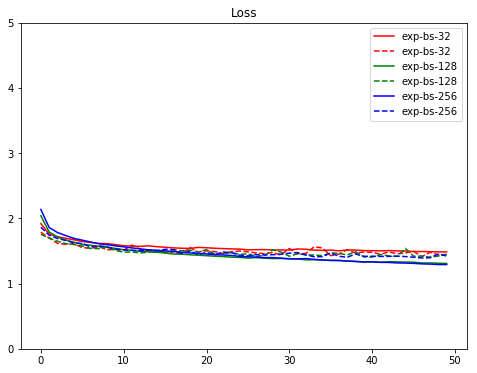

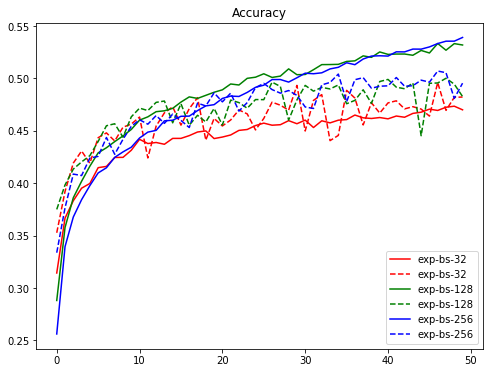

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()